# House prices prediction (kaggle.com)
In the Ames Housing dataset on kaggle, we would like to predict house prices with regression models. Thanks to @Serigne on kaggle.com for some helpful hints. 

### Import Libraries

In [1]:
import pandas as pd
from sklearn import model_selection, linear_model, ensemble, metrics
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.base import clone
from sklearn.kernel_ridge import KernelRidge

## 1. Import and explore the data 

In [2]:
trData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')
data_list = [trData, testData]

In [3]:
print("The size of the training data is {}.".format(trData.shape))
print("The size of the test data is {}.".format(testData.shape))

The size of the training data is (1460, 81).
The size of the test data is (1459, 80).


The test and train data have almost the same number of samples (~1460)! 

In [4]:
trData.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
trData.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


## 2. Clean, fill in the missing data, and remove outliers

What are the missing data? 

In [6]:
trData.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
nullCounts = trData.isnull().sum()
nullCounts[nullCounts > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [8]:
nullCountsTest = testData.isnull().sum()
nullCountsTest[nullCountsTest > 0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [9]:
def CheckNull(df, feature):
    print(df[feature].isnull().sum())

### 2.1 Fill in the missing data
We fill in the missing data with either mean() or mode(). 

In [10]:
testData['TotalBsmtSF'].fillna(testData['TotalBsmtSF'].mean(), inplace = True)
testData['GarageArea'].fillna(testData['GarageArea'].mean(), inplace = True)
testData['MSZoning'].fillna(testData['MSZoning'].mode()[0], inplace = True)
testData['SaleType'].fillna(testData['SaleType'].mode()[0], inplace = True)
for data in data_list:
    data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace = True)
    data['BsmtQual'].fillna(data['BsmtQual'].mode()[0], inplace = True)
    data['Functional'].fillna(data['Functional'].mode()[0], inplace = True)
    data['GarageYrBlt'].fillna(data['GarageYrBlt'].mean(), inplace = True)
    data['GarageCars'].fillna(data['GarageCars'].mode()[0], inplace = True)
    data['Electrical'].fillna(data['Electrical'].mode()[0], inplace = True)
    data['MasVnrType'].fillna(data['MasVnrType'].mode()[0], inplace = True)
    data['MasVnrArea'].fillna(data['MasVnrArea'].mean(), inplace = True)
    data['BsmtCond'].fillna(data['BsmtCond'].mode()[0], inplace = True)
    data['BsmtExposure'].fillna(data['BsmtExposure'].mode()[0], inplace = True)
    data['GarageType'].fillna(data['GarageType'].mode()[0], inplace = True)
    data['BsmtFinSF1'].fillna(data['BsmtFinSF1'].mean(), inplace = True)
    data['PoolQC'].fillna('None', inplace = True)
    data['MiscFeature'].fillna('None', inplace = True)
    data['Alley'].fillna('None', inplace = True)
    data['Fence'].fillna('None', inplace = True)

In [11]:
for data in data_list:
    data['GarageTypeSmple'] = data['GarageType']
    data['GarageTypeSmple'] = data['GarageType'].replace(['Basment', 'CarPort', '2Types'], 'Rare')
    data['ExterCondSmple'] = data['ExterCond'].replace(['Fa', 'Ex', 'Po'], 'Rare')
    data['HasDeckPorch'] = ((data['WoodDeckSF'] > 0) | (data['OpenPorchSF'] > 0) | (data['EnclosedPorch']) > 0 |
                            (data['3SsnPorch'] > 0) | (data['ScreenPorch'] > 0)) * 1
    data['HasPool'] = (data['PoolArea'] > 0) * 1
    data['HalfFullBath'] = data['FullBath'] + data['HalfBath']
    data['SaleTypeSmple'] = data['SaleType'].replace(['CoD', 'ConLD', 'ConLw', 'ConLI', 'Oth', 'Con', 'CWD'], 'Rare')

### 2.2 Convert to numeric
We now convert the non-numeric values to numeric values. 

Transform categorial type features to numeric:

In [12]:
combinedData = pd.concat(objs = [trData, testData], axis = 0).reset_index(drop = True)
Ntr = len(trData)
Ntest = len(testData)
Ntot = len(combinedData)
label = LabelEncoder()
label.fit(combinedData['Neighborhood']) 
labelZone = LabelEncoder()
labelZone.fit(combinedData['MSZoning'])
labelBldgType = LabelEncoder()
labelBldgType.fit(combinedData['BldgType'])
labelHouseStyle = LabelEncoder()
labelHouseStyle.fit(combinedData['HouseStyle'])
labelListOld = ['Neighborhood', 'MSZoning', 'BldgType', 'HouseStyle', 'Foundation', 'CentralAir', 
                'PavedDrive', 'SaleType', 'SaleCondition', 'BsmtQual', 'Heating', 'Functional', 'Street', 
               'ExterCond', 'RoofMatl', 'RoofStyle', 'LandContour', 'Condition1', 'Condition2', 'Electrical',
               'MasVnrType', 'ExterQual', 'GarageTypeSmple', 'ExterCondSmple', 'SaleTypeSmple', 'BsmtCond', 'PoolQC', 
               'MiscFeature', 'Alley', 'Fence']
labelListNew = ['NeighborhoodCode', 'MSZoningCode', 'BldgTypeCode', 'HouseStyleCode', 'FoundationCode', 'CentralAirCode', 
                'PavedDriveCode', 'SaleTypeCode', 'SaleConditionCode', 'BsmtQualCode', 'HeatingCode', 'FunctionalCode', 
               'StreetCode', 'ExterCondCode', 'RoofMatlCode', 'RoofStyleCode', 'LandContour', 'Condition1Code', 
               'Condition2Code', 'ElectricalCode', 'MasVnrTypeCode', 'ExterQualCode', 'GarageTypeSmpleCode', 'ExterCondSmpleCode',
               'SaleTypeSmpleCode', 'BsmtCondCode', 'PoolQCCode', 'MiscFeatureCode', 'AlleyCode', 'FenceCode']

for data in data_list: 
    for i in range(len(labelListOld)):
        label_encoder = LabelEncoder()
        label_encoder.fit(combinedData[labelListOld[i]])
        data[labelListNew[i]] = label_encoder.transform(data[labelListOld[i]])

### Graph the price (output) and features (input) distributions:

Text(0,0.5,'Counts')

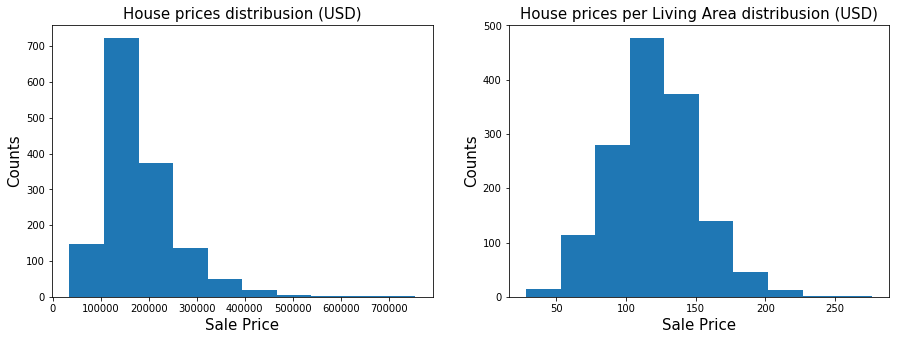

In [13]:
f, ax = plt.subplots(1, 2, figsize = (15, 5))
FZ = 15
ax[0].hist(trData['SalePrice'])
ax[0].set_title('House prices distribusion (USD)', fontsize = FZ)
ax[0].set_xlabel('Sale Price', fontsize = FZ)
ax[0].set_ylabel('Counts', fontsize = FZ)

ax[1].hist(trData['SalePrice'] / trData['GrLivArea'])
ax[1].set_title('House prices per Living Area distribusion (USD)', fontsize = FZ)
ax[1].set_xlabel('Sale Price', fontsize = FZ)
ax[1].set_ylabel('Counts', fontsize = FZ)

In [14]:
trData['PricePerArea'] = trData['SalePrice'] / trData['GrLivArea']
trData['PricePerArea'].mean()

120.57287807326857

For simplicity we will convert the price to $1000:

In [15]:
trData['SalePriceK'] = trData['SalePrice'] / 1000

The average house price per square feet of living area (GrLivArea) is around 120 USD. 

In [16]:
trData["SalePriceLog"] = np.log1p(trData["SalePrice"])

### 2.3 Remove the outliers

Text(0.5,0,'GrLivArea')

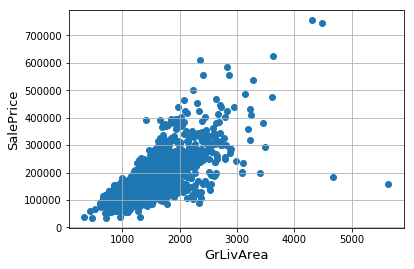

In [17]:
plt.scatter(x = trData['GrLivArea'], y = trData['SalePrice'])
plt.grid()
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

In [18]:
trData.drop(trData[(trData['GrLivArea']>4000) & (trData['SalePrice']<300000)].index, inplace = True)
combinedData = pd.concat(objs = [trData, testData], axis = 0).reset_index(drop = True)

After removing the two outliers:

Text(0.5,0,'GrLivArea')

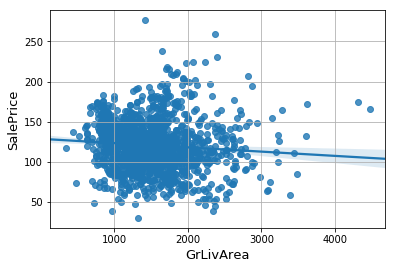

In [19]:
sns.regplot(x = trData['GrLivArea'], y = trData['SalePrice'] /trData['GrLivArea'])
plt.grid()
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

Another possiblity for outliers is the price per area. There is only one house with a price per square foot less than $31, and the next lowest price is $40, so, we remove the cheapest one:

In [20]:
trData[trData['SalePrice'] / trData['GrLivArea'] < 31]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ExterCondSmpleCode,SaleTypeSmpleCode,BsmtCondCode,PoolQCCode,MiscFeatureCode,AlleyCode,FenceCode,PricePerArea,SalePriceK,SalePriceLog
30,31,70,C (all),50.000,8500,Pave,Pave,Reg,3,AllPub,...,1,3,3,3,1,2,2,30.372,40.000,10.597


In [21]:
trData.drop(trData[trData['SalePrice'] / trData['GrLivArea'] < 31].index, inplace = True)

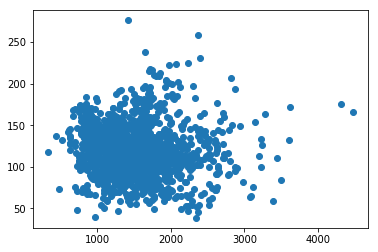

In [22]:
plt.scatter(x = trData['GrLivArea'], y = trData['SalePrice'] / trData['GrLivArea'])

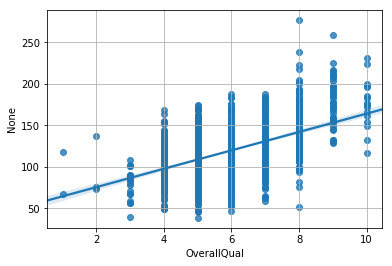

In [23]:
sns.regplot(x = trData['OverallQual'], y = trData['SalePrice'] / trData['GrLivArea'])
plt.grid()

In [24]:
trData['PoolQC'].value_counts()

None    1451
Ex         2
Fa         2
Gd         2
Name: PoolQC, dtype: int64

## 3. Feature engineering
We investigate the correlation between the features and the sale price.

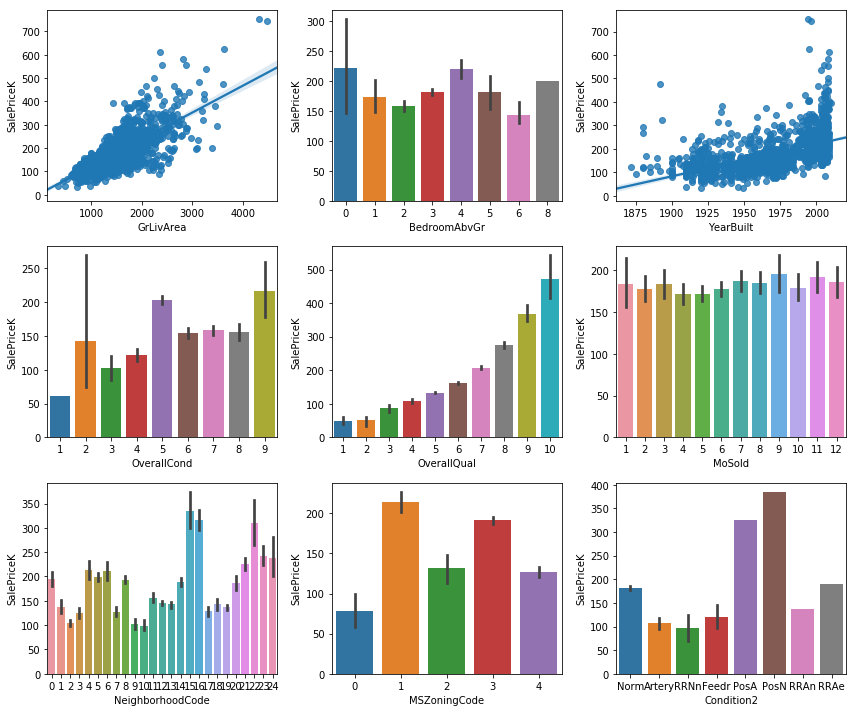

In [25]:
f, ax = plt.subplots(3, 3, figsize = (12, 10))
plt.subplot(3, 3, 1)
sns.regplot(x = 'GrLivArea', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 2)
sns.barplot(x = 'BedroomAbvGr', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 3)
sns.regplot(x = 'YearBuilt', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 4)
sns.barplot(x = 'OverallCond', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 5)
sns.barplot(x = 'OverallQual', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 6)
sns.barplot(x = 'MoSold', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 7)
sns.barplot(x = 'NeighborhoodCode', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 8)
sns.barplot(x = 'MSZoningCode', y = 'SalePriceK', data = trData)
plt.subplot(3, 3, 9)
sns.barplot(x = 'Condition2', y = 'SalePriceK', data = trData)
plt.tight_layout() 

None    1367
Grvl      50
Pave      40
Name: Alley, dtype: int64
0


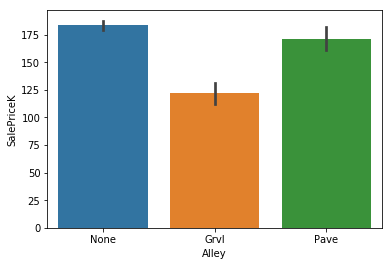

In [26]:
# tmpData = trData
# tmpData['1stFlrSF_2ndFlrSF'] = trData['1stFlrSF'] + trData['2ndFlrSF']
sns.barplot(x = 'Alley', y = 'SalePriceK', data = trData)
print(trData['Alley'].value_counts())
CheckNull(combinedData, 'BsmtCond')

In [27]:
CheckNull(combinedData, 'ExterQual')

0


In [28]:
for data in data_list:
    data['GarageCarsSmple'] = data['GarageCars'].replace(4, 3)

2    612
1    468
3    352
4     22
0      3
Name: HalfFullBath, dtype: int64


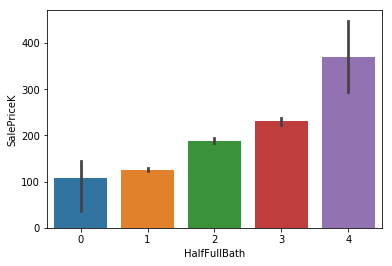

In [29]:
sns.barplot(x = 'HalfFullBath', y = 'SalePriceK', data = trData)
print(trData['HalfFullBath'].value_counts())

1    1063
0     394
Name: HasDeckPorch, dtype: int64


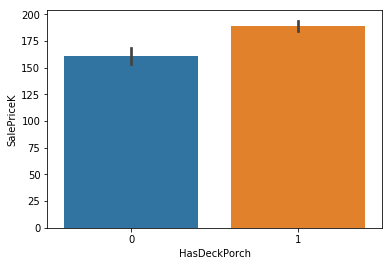

In [30]:
sns.barplot(x = 'HasDeckPorch', y = 'SalePriceK', data = trData)
print(trData['HasDeckPorch'].value_counts())

Gd    378
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64
1420


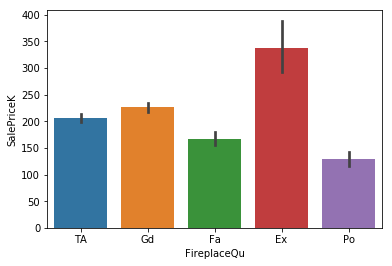

In [31]:
sns.barplot(x = 'FireplaceQu', y = 'SalePriceK', data = trData)
print(trData['FireplaceQu'].value_counts())
CheckNull(combinedData, 'FireplaceQu')

Since only 'Gd' condition has a significant different with the rest, we define a new feature: 

In [32]:
for data in data_list:
    data['BsmtExposureGd'] = (data['BsmtExposure'] == 'Gd') * 1

In [33]:
for data in data_list:
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

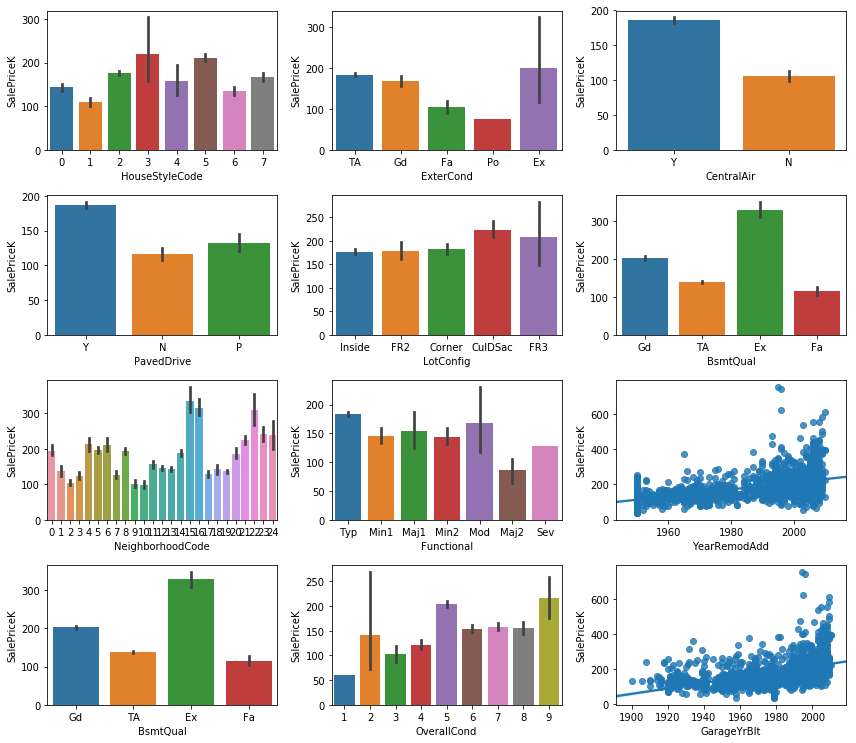

In [34]:
f, ax = plt.subplots(3, 3, figsize = (12, 10))
plt.subplot(4, 3, 1)
sns.barplot(x = 'HouseStyleCode', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 2)
sns.barplot(x = 'ExterCond', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 3)
sns.barplot(x = 'CentralAir', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 4)
sns.barplot(x = 'PavedDrive', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 5)
sns.barplot(x = 'LotConfig', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 6)
sns.barplot(x = 'BsmtQual', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 7)
sns.barplot(x = 'NeighborhoodCode', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 8)
sns.barplot(x = 'Functional', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 9)
sns.regplot(x = 'YearRemodAdd', y = 'SalePriceK', data = trData)
plt.tight_layout() 
plt.subplot(4, 3, 10) 
sns.barplot(x = 'BsmtQual', y = 'SalePriceK', data = trData)
plt.subplot(4, 3, 11) 
sns.barplot(x = 'OverallCond', y = 'SalePriceK', data = trData) 
plt.subplot(4, 3, 12) 
sns.regplot(x = 'GarageYrBlt', y = 'SalePriceK', data = trData)

House age seems to be an important feature correlated with the saleprice:

In [35]:
trData['YearBuilt'].describe()

count   1457.000
mean    1971.253
std       30.174
min     1872.000
25%     1954.000
50%     1973.000
75%     2000.000
max     2010.000
Name: YearBuilt, dtype: float64

In [36]:
for data in data_list:
    data['HouseAge'] = data['YrSold'] - data['YearBuilt']
    data['YrfromRemod'] = data['YrSold'] - data['YearRemodAdd']
    data['YrSoldFrom2006'] = data['YrSold'] - 2006
    data['YrBuiltFrom1971'] = data['YearBuilt'] - 1971

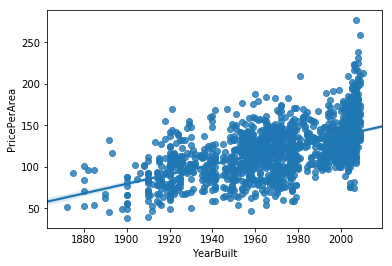

In [37]:
sns.regplot(x = 'YearBuilt', y = 'PricePerArea', data = trData)

In [38]:
cor_col = ['GrLivArea', 'HouseAge', 'OverallCond', 'OverallQual', 'KitchenAbvGr', 'GarageArea', 
           'Functional', 'TotalBsmtSF',  'MSSubClass', 'NeighborhoodCode', 'MSZoningCode',
           'BldgTypeCode', 'HouseStyleCode', 'FoundationCode', 'CentralAirCode', 'PavedDriveCode', 
           'LotArea', 'RoofStyleCode', 'SalePrice']

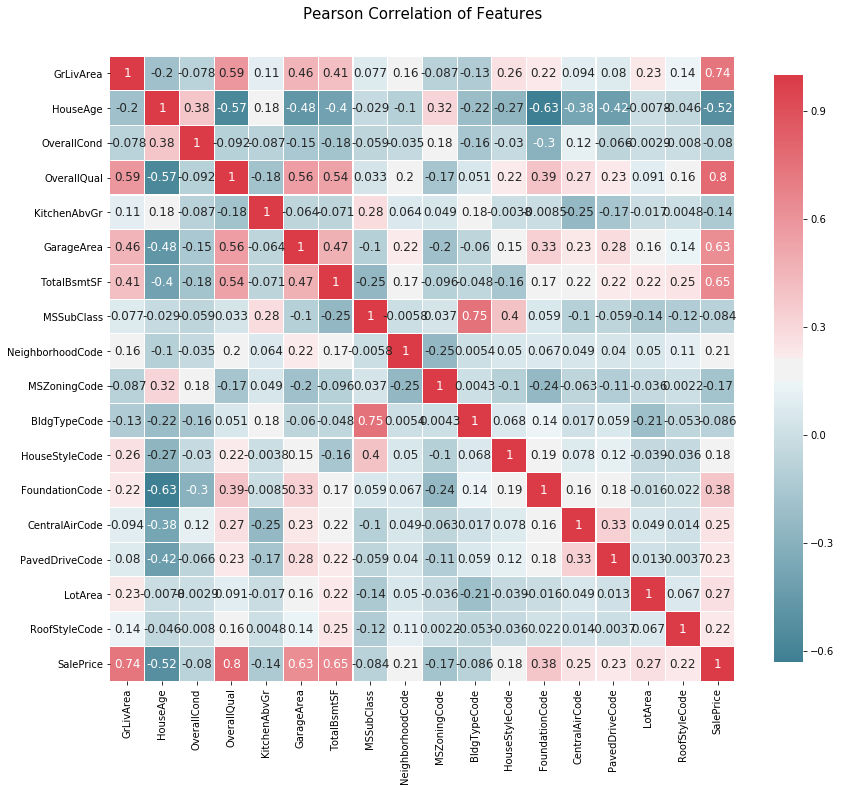

In [39]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(trData[cor_col])

In [40]:
combinedData['Condition2'].value_counts()

Norm      2888
Feedr       13
Artery       5
PosA         4
PosN         3
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

## 4. Train the models and predict

In [41]:
selected_features = ['GrLivArea', 'HouseAge', 'OverallQual', 'BedroomAbvGr', 'KitchenAbvGr', 
                     'FullBath', 'GarageArea', 'Fireplaces', 'MSSubClass', 
                     'MSZoningCode', 'BldgTypeCode', 'HouseStyleCode', 
                     'FoundationCode', 'CentralAirCode', 'PavedDriveCode', 'LotArea', 
                     'YearRemodAdd', 'BsmtQualCode', 'TotRmsAbvGrd', 'OverallCond', 'LandContour',
                     'MasVnrTypeCode', 'BsmtExposureGd', 'YearBuilt', 'GarageTypeSmpleCode', 'GarageCarsSmple',
                     'HasDeckPorch', 'BsmtFinSF1', 'NeighborhoodCode', 'TotalSF']
# good GarageCarsSmple HouseStyleCode CentralAirCode BsmtQualCode OverallCond Fireplaces TotalBsmtSF MSSubClass MSZoningCode
# bad BsmtExposureGd GarageArea FoundationCode LandContour HasDeckPorch FullBath MasVnrTypeCode BedroomAbvGr
# bad PavedDriveCode BldgTypeBsmtExposureGdCode GarageTypeSmpleCode KitchenAbvGr
selected_features = ['GrLivArea', 'OverallQual', 'BsmtFinSF1', 'HouseAge', 'NeighborhoodCode', 'YearRemodAdd', 
                    'GarageCarsSmple', 'LotArea', 'OverallCond', 'Fireplaces',
                    'HouseStyleCode', 'MSSubClass',  'BsmtQualCode', 'PavedDriveCode', 'MasVnrTypeCode', 'TotalSF'
                    ]

X = trData[selected_features]
y = trData['SalePrice']

In [42]:
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(X, y, test_size = 0.5, train_size = 0.5, random_state=1)

In [43]:
n_folds = 10
def rmsle_cv(model):
    kf = model_selection.KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    rmse= np.sqrt(-model_selection.cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(sum(rmse)/n_folds)

In [44]:
clfList = [linear_model.LinearRegression(), ensemble.RandomForestRegressor(), ensemble.GradientBoostingRegressor(),
          xgb.XGBRegressor()]
cvSplit = model_selection.ShuffleSplit(n_splits = 10, train_size = 0.5, test_size = 0.5, random_state = 0)
maxDepthList = [2, 4, 6, 8, 10]
nEstimatorsList = [10, 50, 100, 300]
etaList = [0.1, 0.05, 0.01]
gridSeedList = [0]
gammaList = [0, 0.1, 0.2, 0.5, 1]
colsample_bytreeList = [0.4, 0.5, 0.6, 1]
gridBool = [True, False]
paramGridList = [
                [{'fit_intercept': gridBool}], [{'max_depth': maxDepthList, 'random_state': gridSeedList}],
                [{'n_estimators': nEstimatorsList, 'max_depth': maxDepthList, 'random_state': gridSeedList}], 
                [{'max_depth': maxDepthList, 'gamma': gammaList, 'colsample_bytree': colsample_bytreeList}],
                [{}]
                ]
bestScoreList = []
for clf, param in zip(clfList, paramGridList):
    bestSearch = model_selection.GridSearchCV(estimator = clf, param_grid = param, 
                                              cv = cvSplit, scoring = 'neg_mean_squared_error', n_jobs = 4)
    bestSearch.fit(X, y)
    bestParam = bestSearch.best_params_
    bestScore = round((-bestSearch.best_score_)**0.5, 5) / 1000
    print('The best parameter for {} is {} with a runtime of seconds with an error of {}'.format(clf.__class__.__name__, bestParam, bestScore))
    clf.set_params(**bestParam) 
    bestScoreList.append(bestScore)
print("--"*45, "\nMax cross-validation score is {}".format(round(min(bestScoreList), 5)))
print("--"*45, "\nAverage cross-validation score is {}".format(sum(sorted(bestScoreList, reverse=False)[0:3]) / 3))

The best parameter for LinearRegression is {'fit_intercept': False} with a runtime of seconds with an error of 29.23478659
The best parameter for RandomForestRegressor is {'random_state': 0, 'max_depth': 10} with a runtime of seconds with an error of 28.36783028
The best parameter for GradientBoostingRegressor is {'random_state': 0, 'n_estimators': 300, 'max_depth': 2} with a runtime of seconds with an error of 23.82912717
The best parameter for XGBRegressor is {'colsample_bytree': 0.6, 'gamma': 0, 'max_depth': 4} with a runtime of seconds with an error of 24.50810766
------------------------------------------------------------------------------------------ 
Max cross-validation score is 23.82913
------------------------------------------------------------------------------------------ 
Average cross-validation score is 25.568355036666663


In [45]:
# Thanks to Serigne on kaggle.com
class AveragingModels():
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [46]:
LassoRobust = make_pipeline(RobustScaler(), linear_model.Lasso(alpha =100, random_state=1))
ENet = make_pipeline(RobustScaler(), linear_model.ElasticNet(alpha=0.5, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [47]:
# averaging
averagingC = AveragingModels(models = (clfList[2], clfList[3]))
averagingC.fit(Xtrain, ytrain) # Note we fit the Whole X, y
arpredict = averagingC.predict(Xtest)
print(metrics.mean_squared_log_error(ytest, arpredict)**0.5)
predData = pd.DataFrame({'Index':ytest.index, 'SalePrice': ytest.values, 'SalePricePredicted':arpredict,
                         'Error': arpredict - ytest.values})

0.125849403586


In [48]:
averagingC.fit(X, y) # Note we fit the Whole X, y
arpredict = averagingC.predict(Xtest)
print(metrics.mean_squared_log_error(ytest, arpredict)**0.5)
predData = pd.DataFrame({'Index':ytest.index, 'SalePrice': ytest.values, 'SalePricePredicted':arpredict,
                         'Error': arpredict - ytest.values})

0.09096960921


In [49]:
# votingC = clfList[2]
# votingC.fit(Xtrain, ytrain) # Note we fit the Whole X, y
# arpredict = votingC.predict(Xtest)
# print(metrics.mean_squared_log_error(ytest, arpredict)**0.5)
# predData = pd.DataFrame({'Index':ytest.index, 'SalePrice': ytest.values, 'SalePricePredicted':arpredict,
#                          'Error': arpredict - ytest.values})

In [50]:
# votingC = clfList[2]
# votingC.fit(X, y) # Note we fit the Whole X, y
# arpredict = votingC.predict(Xtest)
# print(metrics.mean_squared_log_error(ytest, arpredict)**0.5)
# predData = pd.DataFrame({'Index':ytest.index, 'SalePrice': ytest.values, 'SalePricePredicted':arpredict,
#                          'Error': arpredict - ytest.values})

In [51]:
trsh = 100000
print(len(Xtest[abs(arpredict - ytest.values) > trsh]))
predData[abs(arpredict - ytest.values) > trsh]

0


,Error,Index,SalePrice,SalePricePredicted


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

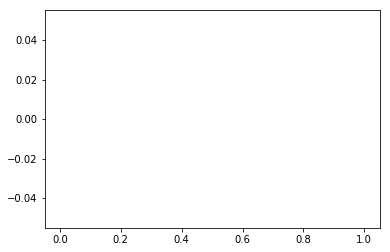

In [52]:
plt.hist(Xtest[abs(arpredict - ytest.values) > trsh]['OverallQual'])

In [53]:
ytest[abs(arpredict - ytest.values) > 100000]

Series([], Name: SalePrice, dtype: int64)

In [54]:
testDataTemp = testData[selected_features]
arpredict = averagingC.predict(testDataTemp)
ypredict = pd.DataFrame({'Id': testData['Id'], 'SalePrice':arpredict})
ypredict.to_csv('../predictions.csv', index = False)

In [55]:
ypredict.head()

,Id,SalePrice
0,1461,125692.345
1,1462,157033.147
2,1463,189975.720
3,1464,188429.673
4,1465,195434.694
